In [33]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from qiskit.quantum_info import Statevector
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from scipy.linalg import block_diag
from scipy.sparse import bmat 
from qiskit.quantum_info import state_fidelity
from gibbs.utils import number_of_elements, simple_purify_hamiltonian, spectral_dec,printarray
from gibbs.plots.plots import preparation
# plt.rcParams['text.usetex'] = True

%load_ext autoreload
import os
gibbs_result_list = []
folder_path = "../scripts_lap/job_6_Sherbroke/"
for file in os.listdir(folder_path):
    if file.endswith(".npy"):
        path = os.path.join(folder_path, file)
        gibbs_result_list.append(GibbsResult.load(path))
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from gibbs.utils import state_from_ansatz
timestep = -2
g : GibbsResult = gibbs_result_list[0]
print(g.betas)

[0.0, 0.1, 0.2]


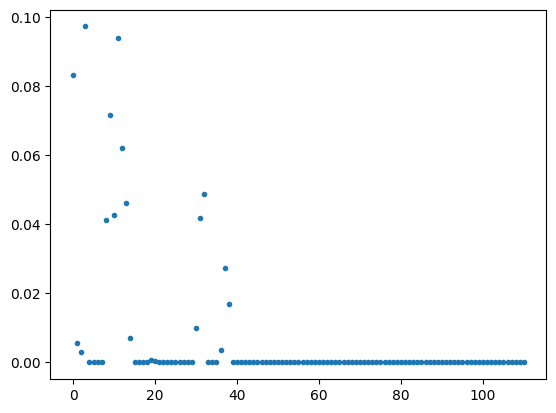

In [61]:
plt.plot(np.abs(g.cfaulties[2]),linestyle="None",marker=".")

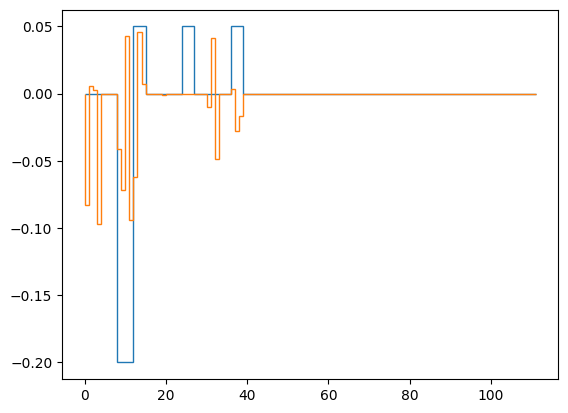

In [26]:
plt.stairs(g.coriginal*g.betas[timestep])
plt.stairs(g.cfaulties[timestep])

[0.07513341 0.06151033 0.07479773 0.06458692 0.06216849 0.05088839
 0.06880292 0.0594072  0.07057394 0.05777754 0.07025546 0.06066469
 0.05757288 0.04712661 0.06371737 0.0550161 ]


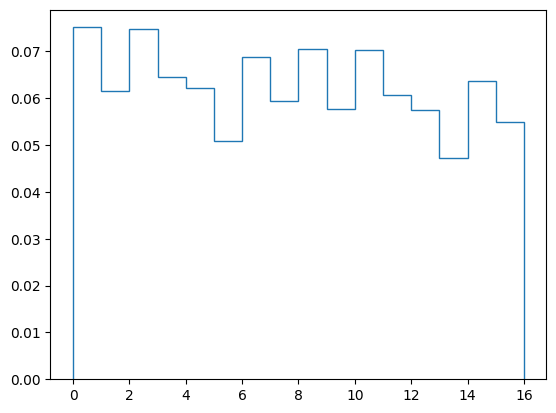

In [27]:
probs_class = np.real(np.diagonal(state_from_ansatz(g.ansatz,g.parameters[timestep])))
print(probs_class)
plt.stairs(probs_class)

In [3]:
from qiskit.providers.fake_provider import FakeMelbourne
from qiskit_aer.backends import QasmSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
# Make a noise model
fake_backend = FakeMelbourne()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = {
    "noise_model": noise_model,
    "basis_gates": fake_backend.configuration().basis_gates,
    "coupling_map": fake_backend.configuration().coupling_map,
    "seed_simulator": 42,
}

# # Set number of shots, optimization_level and resilience_level
# options.execution.shots = 10000
# options.optimization_level = 0
# options.resilience_level = 1
backend = QasmSimulator.from_backend(fake_backend)
sampler = Sampler(backend_options=options)

In [4]:
qc = g.ansatz.copy()
from qiskit.circuit import ClassicalRegister
qc.add_register(ClassicalRegister(4))
qc.measure(range(4),range(4))
result = sampler.run([qc],[g.parameters[timestep]],shots=1e7)

In [5]:
quasi_dist = list(dict(sorted(result.result().quasi_dists[0].items())).values())

In [6]:
from gibbs.utils import expected_state
expected_probs = np.diagonal(np.real(expected_state(g.basis.vector_to_pauli_op(g.coriginal),g.betas[timestep])))
print(expected_probs)

[0.08246059 0.07202444 0.07544929 0.06005157 0.07544929 0.06589635
 0.06290908 0.05006735 0.07202444 0.06290908 0.06589635 0.05244812
 0.06005157 0.05244812 0.05006735 0.03984702]


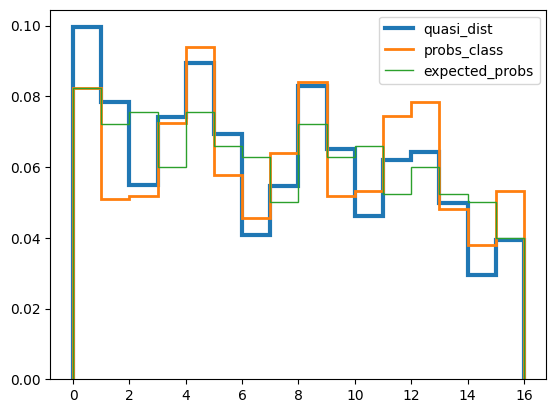

In [13]:
plt.stairs(quasi_dist,lw=3,label = "quasi_dist")
plt.stairs(probs_class,lw=2,label = "probs_class")
plt.stairs(expected_probs,lw=1,label = "expected_probs")
plt.legend()

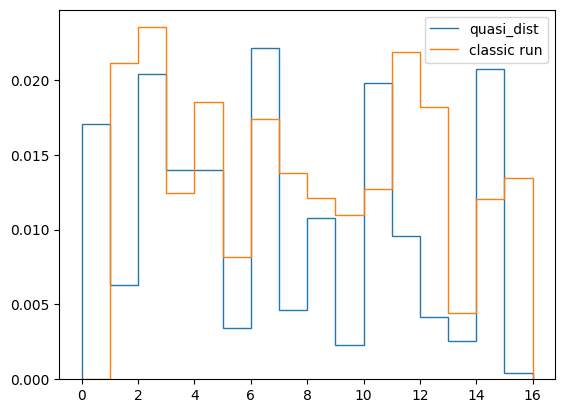

In [14]:
plt.stairs(np.abs(quasi_dist-expected_probs),label="quasi_dist")
plt.stairs(np.abs(probs_class-expected_probs),label="classic run")
plt.legend()